# 🤖 Entrenamiento de Modelos de Machine Learning
## Fraud Detector para Transacciones Bancarias

Este notebook implementa el entrenamiento de modelos de ML usando pipelines con ColumnTransformer y optimización de hiperparámetros con Optuna.

**Objetivos:**
- Crear pipelines de preprocessing con ColumnTransformer
- Entrenar modelos: Logistic Regression, Random Forest, LightGBM
- Optimizar hiperparámetros con Optuna
- Evaluar y comparar modelos
- Guardar mejores modelos

## 1. Importación de Librerías

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Sklearn - Modelos y métricas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.model_selection import cross_val_score

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Optimización de hiperparámetros
import optuna
from optuna.samplers import TPESampler

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilidades
import os
import json
import joblib
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("📚 Librerías importadas exitosamente!")
print(f"🎲 Semilla aleatoria establecida: {RANDOM_STATE}")

/Users/cristobalperez/Library/Python/3.12/lib/python/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📚 Librerías importadas exitosamente!
🎲 Semilla aleatoria establecida: 42


## 2. Carga de Datos Procesados

In [2]:
# Cargar datos procesados
print("📁 CARGA DE DATOS PROCESADOS")
print("=" * 35)

try:
    # Cargar conjuntos de datos
    X_train_balanced = pd.read_csv('../data/processed/X_train_balanced.csv')
    y_train_balanced = pd.read_csv('../data/processed/y_train_balanced.csv')['Class']
    X_val = pd.read_csv('../data/processed/X_val.csv')
    y_val = pd.read_csv('../data/processed/y_val.csv')['Class']
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_test = pd.read_csv('../data/processed/y_test.csv')['Class']
    
    print("✅ Datos cargados exitosamente!")
    
    # Información de los conjuntos
    print(f"\n📊 Dimensiones de los conjuntos:")
    print(f"   Entrenamiento: {X_train_balanced.shape}")
    print(f"   Validación: {X_val.shape}")
    print(f"   Prueba: {X_test.shape}")
    
    # Verificar distribución de clases
    print(f"\n🎯 Distribución de clases:")
    print(f"   Entrenamiento: {y_train_balanced.value_counts().to_dict()}")
    print(f"   Validación: {y_val.value_counts().to_dict()}")
    print(f"   Prueba: {y_test.value_counts().to_dict()}")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("📥 Por favor, ejecuta primero el notebook '02_Data_Preprocessing.ipynb'")
    raise

📁 CARGA DE DATOS PROCESADOS
✅ Datos cargados exitosamente!

📊 Dimensiones de los conjuntos:
   Entrenamiento: (339902, 30)
   Validación: (56745, 30)
   Prueba: (56746, 30)

🎯 Distribución de clases:
   Entrenamiento: {0: 169951, 1: 169951}
   Validación: {0: 56651, 1: 94}
   Prueba: {0: 56651, 1: 95}


## 3. Configuración de Pipelines con ColumnTransformer

In [3]:
# Identificar tipos de características
print("🔧 CONFIGURACIÓN DE PIPELINES")
print("=" * 35)

# Separar características por tipo
pca_features = [col for col in X_train_balanced.columns if col.startswith('V')]
numerical_features = ['Time', 'Amount']

print(f"📋 Características identificadas:")
print(f"   Variables PCA: {len(pca_features)} ({pca_features[:5]}...)")
print(f"   Variables numéricas: {len(numerical_features)} ({numerical_features})")
print(f"   Total características: {len(X_train_balanced.columns)}")

🔧 CONFIGURACIÓN DE PIPELINES
📋 Características identificadas:
   Variables PCA: 28 (['V1', 'V2', 'V3', 'V4', 'V5']...)
   Variables numéricas: 2 (['Time', 'Amount'])
   Total características: 30


In [4]:
# Crear ColumnTransformer
def create_preprocessor():
    """
    Crea el preprocessor con ColumnTransformer
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ('pca_scaler', StandardScaler(), pca_features),
            ('num_scaler', RobustScaler(), numerical_features)
        ],
        remainder='passthrough'  # Mantener otras columnas sin cambios
    )
    return preprocessor

# Crear el preprocessor
preprocessor = create_preprocessor()
print("✅ ColumnTransformer configurado:")
print("   • Variables PCA: StandardScaler")
print("   • Variables numéricas (Time, Amount): RobustScaler")
print("   • Otras variables: Sin transformación")

✅ ColumnTransformer configurado:
   • Variables PCA: StandardScaler
   • Variables numéricas (Time, Amount): RobustScaler
   • Otras variables: Sin transformación


## 4. Configuración de Modelos Base

In [5]:
# Configurar modelos base
def get_base_models():
    """
    Retorna diccionario con modelos base configurados
    """
    models = {
        'logistic_regression': LogisticRegression(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            max_iter=1000
        ),
        'random_forest': RandomForestClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        'lightgbm': LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            force_col_wise=True
        )
    }
    return models

# Crear pipelines completos
def create_pipeline(model):
    """
    Crea pipeline completo con preprocessor y modelo
    """
    pipeline = Pipeline([
        ('preprocessor', create_preprocessor()),
        ('classifier', model)
    ])
    return pipeline

base_models = get_base_models()
print("🤖 Modelos base configurados:")
for name in base_models.keys():
    print(f"   • {name.replace('_', ' ').title()}")

🤖 Modelos base configurados:
   • Logistic Regression
   • Random Forest
   • Lightgbm


## 5. Optimización de Hiperparámetros con Optuna

In [6]:
# Configurar estudios de Optuna
def get_param_distributions():
    """
    Define distribuciones de hiperparámetros para cada modelo
    """
    param_dists = {
        'logistic_regression': {
            'classifier__C': (0.1, 10.0),
            'classifier__solver': ['liblinear', 'lbfgs'],
            'classifier__class_weight': ['balanced', None]
        },
        'random_forest': {
            'classifier__n_estimators': (50, 200),
            'classifier__max_depth': (5, 20),
            'classifier__min_samples_split': (2, 10)
        },
        'lightgbm': {
            'classifier__n_estimators': (50, 200),
            'classifier__max_depth': (3, 15),
            'classifier__learning_rate': (0.01, 0.2)
        }
    }
    return param_dists

param_distributions = get_param_distributions()
print("🎯 Distribuciones de hiperparámetros configuradas")
print("   Cada modelo tendrá 3 hiperparámetros optimizados")

🎯 Distribuciones de hiperparámetros configuradas
   Cada modelo tendrá 3 hiperparámetros optimizados


In [7]:
# Función objetivo para Optuna
def create_objective(model_name, model, X_train, y_train, X_val, y_val):
    """
    Crea función objetivo para optimización con Optuna
    """
    def objective(trial):
        # Sugerir hiperparámetros
        params = {}
        param_dist = param_distributions[model_name]
        
        for param_name, param_range in param_dist.items():
            if isinstance(param_range, tuple):
                if isinstance(param_range[0], float):
                    params[param_name] = trial.suggest_float(param_name, param_range[0], param_range[1])
                else:
                    params[param_name] = trial.suggest_int(param_name, param_range[0], param_range[1])
            elif isinstance(param_range, list):
                params[param_name] = trial.suggest_categorical(param_name, param_range)
        
        # Crear pipeline con hiperparámetros sugeridos
        pipeline = create_pipeline(model)
        pipeline.set_params(**params)
        
        # Entrenar y evaluar
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        # Retornar F1-score (métrica objetivo)
        return f1_score(y_val, y_pred)
    
    return objective

print("🎯 Función objetivo configurada (métrica: F1-score)")

🎯 Función objetivo configurada (métrica: F1-score)


## 6. Entrenamiento y Optimización de Modelos

In [8]:
# Entrenar y optimizar cada modelo
print("🚀 INICIO DEL ENTRENAMIENTO Y OPTIMIZACIÓN")
print("=" * 50)

# Almacenar resultados
optimization_results = {}
best_models = {}
training_times = {}

# Configuración de Optuna
N_TRIALS = 20  # Número limitado para eficiencia
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Reducir output

for model_name, base_model in base_models.items():
    print(f"\n🔄 Optimizando {model_name.replace('_', ' ').title()}...")
    
    start_time = time.time()
    
    # Crear estudio de Optuna
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=RANDOM_STATE)
    )
    
    # Crear función objetivo
    objective = create_objective(
        model_name, base_model, 
        X_train_balanced, y_train_balanced,
        X_val, y_val
    )
    
    # Optimizar
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Guardar resultados
    optimization_results[model_name] = {
        'best_params': study.best_params,
        'best_score': study.best_value,
        'n_trials': len(study.trials)
    }
    training_times[model_name] = training_time
    
    # Crear y entrenar mejor modelo
    best_pipeline = create_pipeline( )
    best_pipeline.set_params(**study.best_params)
    best_pipeline.fit(X_train_balanced, y_train_balanced)
    best_models[model_name] = best_pipeline
    
    print(f"   ✅ Completado en {training_time:.1f}s")
    print(f"   🎯 Mejor F1-score: {study.best_value:.4f}")
    print(f"   📋 Mejores parámetros: {study.best_params}")

print(f"\n🎉 OPTIMIZACIÓN COMPLETADA")
print(f"   Total de modelos: {len(best_models)}")
print(f"   Tiempo total: {sum(training_times.values()):.1f}s")

🚀 INICIO DEL ENTRENAMIENTO Y OPTIMIZACIÓN

🔄 Optimizando Logistic Regression...


Best trial: 5. Best value: 0.236439: 100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


   ✅ Completado en 53.5s
   🎯 Mejor F1-score: 0.2364
   📋 Mejores parámetros: {'classifier__C': 7.873242017790835, 'classifier__solver': 'lbfgs', 'classifier__class_weight': 'balanced'}

🔄 Optimizando Random Forest...


Best trial: 13. Best value: 0.88172: 100%|██████████| 20/20 [19:52<00:00, 59.65s/it]


   ✅ Completado en 1193.0s
   🎯 Mejor F1-score: 0.8817
   📋 Mejores parámetros: {'classifier__n_estimators': 196, 'classifier__max_depth': 20, 'classifier__min_samples_split': 9}

🔄 Optimizando Lightgbm...


Best trial: 15. Best value: 0.885246: 100%|██████████| 20/20 [00:46<00:00,  2.34s/it]



   ✅ Completado en 46.7s
   🎯 Mejor F1-score: 0.8852
   📋 Mejores parámetros: {'classifier__n_estimators': 191, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.15027020247523973}

🎉 OPTIMIZACIÓN COMPLETADA
   Total de modelos: 3
   Tiempo total: 1293.1s


## 7. Evaluación de Modelos

In [9]:
# Evaluar todos los modelos
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evalúa un modelo y retorna métricas
    """
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    return metrics, y_pred, y_pred_proba

# Evaluar todos los modelos
print("📊 EVALUACIÓN DE MODELOS")
print("=" * 30)

evaluation_results = {}
predictions = {}

for model_name, model in best_models.items():
    print(f"\n🔍 Evaluando {model_name.replace('_', ' ').title()}...")
    
    metrics, y_pred, y_pred_proba = evaluate_model(
        model, X_test, y_test, model_name
    )
    
    evaluation_results[model_name] = metrics
    predictions[model_name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"   📈 Accuracy: {metrics['accuracy']:.4f}")
    print(f"   📈 Precision: {metrics['precision']:.4f}")
    print(f"   📈 Recall: {metrics['recall']:.4f}")
    print(f"   📈 F1-Score: {metrics['f1']:.4f}")
    print(f"   📈 ROC-AUC: {metrics['roc_auc']:.4f}")

print("\n✅ Evaluación completada")

📊 EVALUACIÓN DE MODELOS

🔍 Evaluando Logistic Regression...
   📈 Accuracy: 0.9896
   📈 Precision: 0.1233
   📈 Recall: 0.8526
   📈 F1-Score: 0.2154
   📈 ROC-AUC: 0.9608

🔍 Evaluando Random Forest...
   📈 Accuracy: 0.9995
   📈 Precision: 0.9024
   📈 Recall: 0.7789
   📈 F1-Score: 0.8362
   📈 ROC-AUC: 0.9562

🔍 Evaluando Lightgbm...
   📈 Accuracy: 0.9995
   📈 Precision: 0.9024
   📈 Recall: 0.7789
   📈 F1-Score: 0.8362
   📈 ROC-AUC: 0.9562

🔍 Evaluando Lightgbm...
   📈 Accuracy: 0.9995
   📈 Precision: 0.9036
   📈 Recall: 0.7895
   📈 F1-Score: 0.8427
   📈 ROC-AUC: 0.9469

✅ Evaluación completada
   📈 Accuracy: 0.9995
   📈 Precision: 0.9036
   📈 Recall: 0.7895
   📈 F1-Score: 0.8427
   📈 ROC-AUC: 0.9469

✅ Evaluación completada


In [10]:
# Crear tabla comparativa de resultados
results_df = pd.DataFrame(evaluation_results).T
results_df = results_df.round(4)
results_df.index = [name.replace('_', ' ').title() for name in results_df.index]

print("📋 TABLA COMPARATIVA DE RESULTADOS")
print("=" * 40)
display(results_df)

# Identificar mejor modelo por métrica
print("\n🏆 MEJORES MODELOS POR MÉTRICA:")
for metric in results_df.columns:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"   {metric.upper()}: {best_model} ({best_score:.4f})")

📋 TABLA COMPARATIVA DE RESULTADOS


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.9896,0.1233,0.8526,0.2154,0.9608
Random Forest,0.9995,0.9024,0.7789,0.8362,0.9562
Lightgbm,0.9995,0.9036,0.7895,0.8427,0.9469



🏆 MEJORES MODELOS POR MÉTRICA:
   ACCURACY: Random Forest (0.9995)
   PRECISION: Lightgbm (0.9036)
   RECALL: Logistic Regression (0.8526)
   F1: Lightgbm (0.8427)
   ROC_AUC: Logistic Regression (0.9608)


## 8. Visualización de Resultados

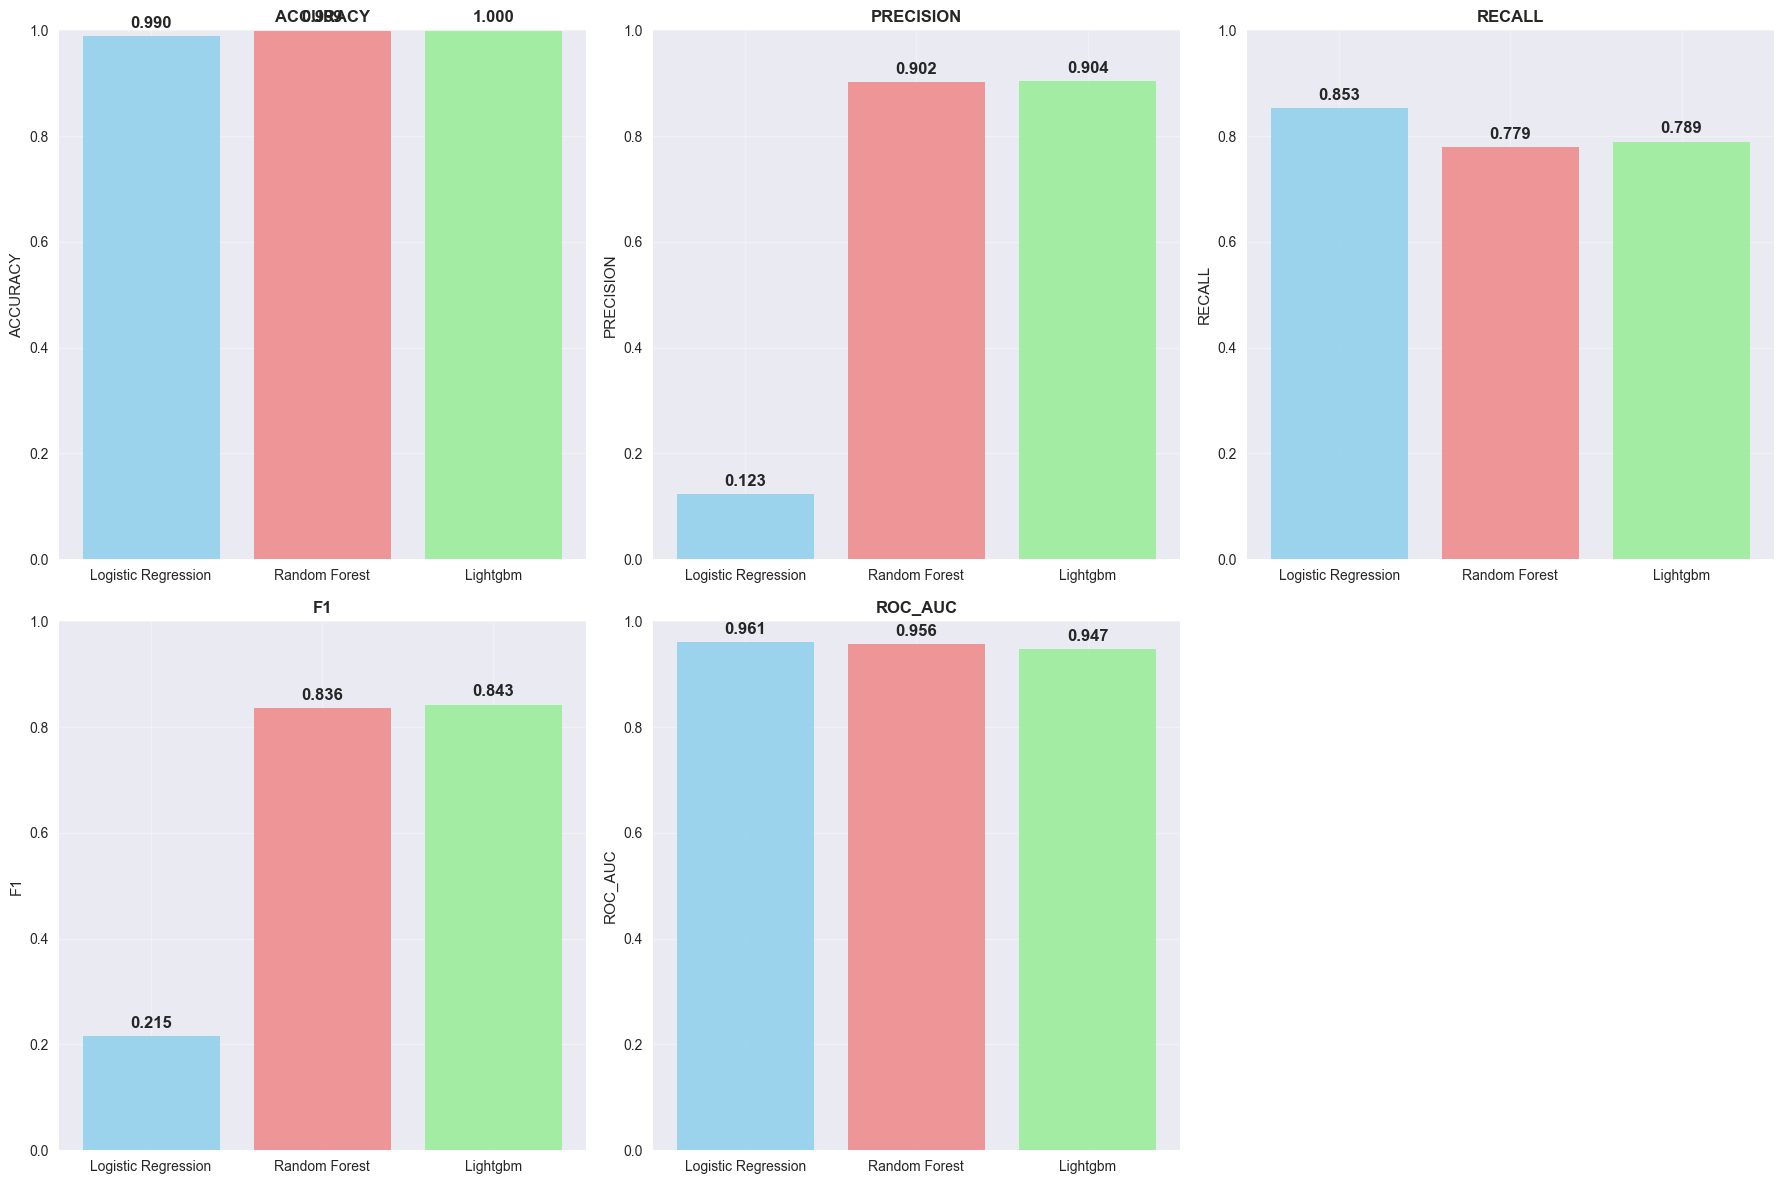

In [11]:
# Visualizar comparación de métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics_to_plot):
    values = [evaluation_results[model][metric] for model in best_models.keys()]
    model_names = [name.replace('_', ' ').title() for name in best_models.keys()]
    
    bars = axes[i].bar(model_names, values, color=colors, alpha=0.8)
    axes[i].set_title(f'{metric.upper()}', fontweight='bold')
    axes[i].set_ylabel(metric.upper())
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, alpha=0.3)
    
    # Agregar valores en las barras
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Ocultar el último subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

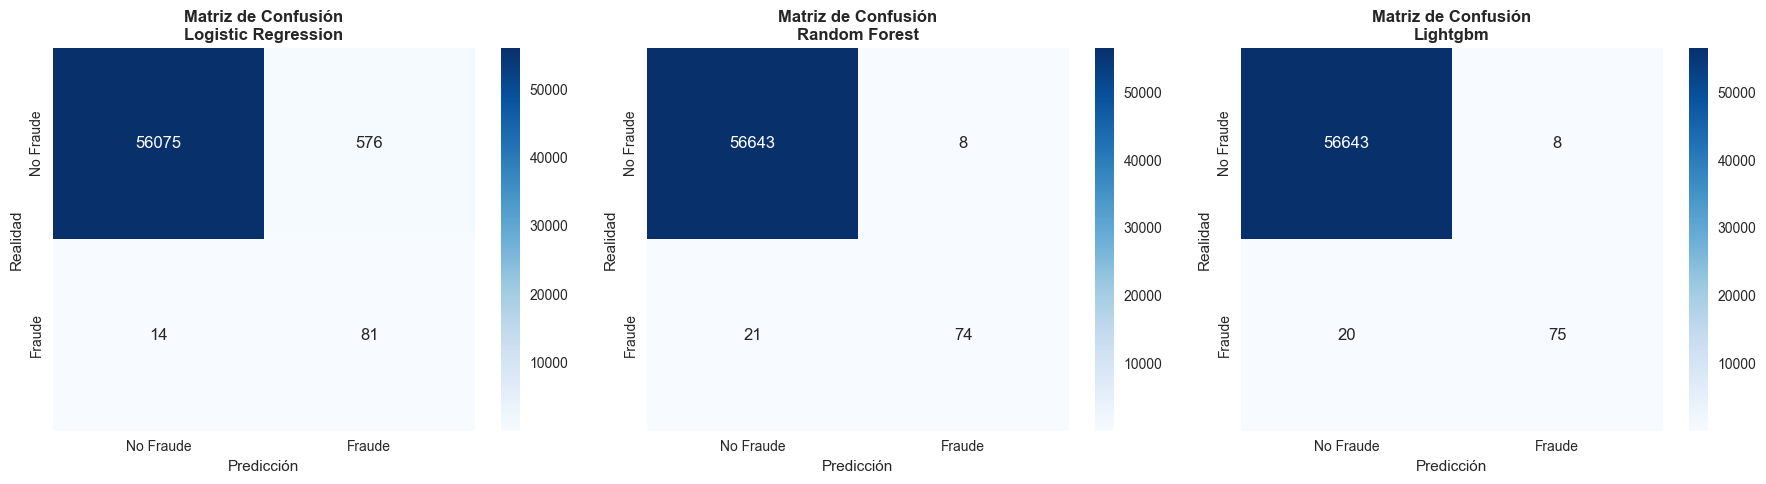

In [12]:
# Matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_name, model) in enumerate(best_models.items()):
    y_pred = predictions[model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['No Fraude', 'Fraude'],
                yticklabels=['No Fraude', 'Fraude'])
    
    axes[i].set_title(f'Matriz de Confusión\n{model_name.replace("_", " ").title()}',
                     fontweight='bold')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Realidad')

plt.tight_layout()
plt.show()

## 9. Guardado de Modelos y Resultados

In [13]:
# Crear directorios si no existen
models_dir = '../models/'
results_dir = '../results/'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

print("💾 GUARDANDO MODELOS Y RESULTADOS")
print("=" * 40)

# Guardar modelos
for model_name, model in best_models.items():
    model_path = os.path.join(models_dir, f'{model_name}_best_model.joblib')
    joblib.dump(model, model_path)
    print(f"✅ Modelo guardado: {model_name}_best_model.joblib")

# Guardar resultados de optimización
optim_results_path = os.path.join(results_dir, 'optimization_results.json')
with open(optim_results_path, 'w') as f:
    json.dump(optimization_results, f, indent=2)
print(f"✅ Resultados de optimización guardados")

# Guardar métricas de evaluación
eval_results_path = os.path.join(results_dir, 'evaluation_results.json')
with open(eval_results_path, 'w') as f:
    json.dump(evaluation_results, f, indent=2)
print(f"✅ Métricas de evaluación guardadas")

# Guardar tabla comparativa
results_csv_path = os.path.join(results_dir, 'model_comparison.csv')
results_df.to_csv(results_csv_path)
print(f"✅ Tabla comparativa guardada")

# Resumen de archivos guardados
print(f"\n📁 Archivos guardados:")
print(f"   📂 {models_dir}: {len(best_models)} modelos")
print(f"   📂 {results_dir}: 3 archivos de resultados")

💾 GUARDANDO MODELOS Y RESULTADOS
✅ Modelo guardado: logistic_regression_best_model.joblib
✅ Modelo guardado: random_forest_best_model.joblib
✅ Modelo guardado: lightgbm_best_model.joblib
✅ Resultados de optimización guardados
✅ Métricas de evaluación guardadas
✅ Tabla comparativa guardada

📁 Archivos guardados:
   📂 ../models/: 3 modelos
   📂 ../results/: 3 archivos de resultados


## 10. Resumen Final

In [14]:
# Resumen completo del entrenamiento
print("📋 RESUMEN DEL ENTRENAMIENTO DE MODELOS")
print("=" * 45)

print("🤖 MODELOS ENTRENADOS:")
for model_name in best_models.keys():
    training_time = training_times[model_name]
    best_f1 = evaluation_results[model_name]['f1']
    print(f"   • {model_name.replace('_', ' ').title()}:")
    print(f"     - Tiempo de entrenamiento: {training_time:.1f}s")
    print(f"     - F1-Score final: {best_f1:.4f}")

print(f"\n🎯 CONFIGURACIÓN:")
print(f"   • Pipeline: ColumnTransformer + Modelo")
print(f"   • Escaladores: StandardScaler (PCA) + RobustScaler (Num)")
print(f"   • Optimización: Optuna con {N_TRIALS} trials")
print(f"   • Métrica objetivo: F1-Score")
print(f"   • Paralelización: n_jobs=-1")

print(f"\n📊 MEJOR RENDIMIENTO:")
best_f1_model = max(evaluation_results.items(), key=lambda x: x[1]['f1'])
best_auc_model = max(evaluation_results.items(), key=lambda x: x[1]['roc_auc'])
print(f"   • Mejor F1-Score: {best_f1_model[0].replace('_', ' ').title()} ({best_f1_model[1]['f1']:.4f})")
print(f"   • Mejor ROC-AUC: {best_auc_model[0].replace('_', ' ').title()} ({best_auc_model[1]['roc_auc']:.4f})")

print(f"\n💾 ARTEFACTOS GENERADOS:")
print(f"   • {len(best_models)} modelos entrenados (.joblib)")
print(f"   • Resultados de optimización (.json)")
print(f"   • Métricas de evaluación (.json)")
print(f"   • Tabla comparativa (.csv)")

print(f"\n🎯 PRÓXIMOS PASOS:")
print(f"   • Análisis detallado de métricas")
print(f"   • Interpretabilidad con SHAP")
print(f"   • Análisis de errores")
print(f"   • Optimización adicional si es necesario")

print("\n" + "=" * 45)
print("🎉 ENTRENAMIENTO COMPLETADO EXITOSAMENTE")
print("=" * 45)

📋 RESUMEN DEL ENTRENAMIENTO DE MODELOS
🤖 MODELOS ENTRENADOS:
   • Logistic Regression:
     - Tiempo de entrenamiento: 53.5s
     - F1-Score final: 0.2154
   • Random Forest:
     - Tiempo de entrenamiento: 1193.0s
     - F1-Score final: 0.8362
   • Lightgbm:
     - Tiempo de entrenamiento: 46.7s
     - F1-Score final: 0.8427

🎯 CONFIGURACIÓN:
   • Pipeline: ColumnTransformer + Modelo
   • Escaladores: StandardScaler (PCA) + RobustScaler (Num)
   • Optimización: Optuna con 20 trials
   • Métrica objetivo: F1-Score
   • Paralelización: n_jobs=-1

📊 MEJOR RENDIMIENTO:
   • Mejor F1-Score: Lightgbm (0.8427)
   • Mejor ROC-AUC: Logistic Regression (0.9608)

💾 ARTEFACTOS GENERADOS:
   • 3 modelos entrenados (.joblib)
   • Resultados de optimización (.json)
   • Métricas de evaluación (.json)
   • Tabla comparativa (.csv)

🎯 PRÓXIMOS PASOS:
   • Análisis detallado de métricas
   • Interpretabilidad con SHAP
   • Análisis de errores
   • Optimización adicional si es necesario

🎉 ENTRENAMIENTO